In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import h5py
import csv
import re
import warnings
warnings.simplefilter("ignore")
top_level_dir = os.path.abspath(os.path.join(os.path.dirname("binning.ipynb"), '..'))
sys.path.append(top_level_dir)

from analysis_package import maxlab_analysis as mla

parent = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/frequency-game"
exp_name = "Multiwell_excite_inhib"
chip_id = "M07480"
date = 240828
trial = 0
well = 0
config_a_file_name = "buttonA.cfg"
config_b_file_name = "buttonB.cfg"

dates = [240828, 240829, 240830, 240903, 240904]


data_path = f"{parent}/{exp_name}/{chip_id}/{date}/{trial}/well{well}/"

csv_file_name = f"button_data_well_{well}.csv"

a_color = "red"
b_color = "blue"


In [23]:
# assuming MaxTwo (10000 Hz)
def frames_to_ms(frames):
    return frames * 0.1

In [24]:
# csv_data = pd.read_csv(data_path + csv_file_name)

In [25]:
# time between each button
# csv_data["press time"] = csv_data["frame number"].diff().apply(frames_to_ms).shift(-1)

In [26]:
# plot histogram of times between button presses
# plt.hist(csv_data["press time"], bins=50)
# plt.title("Frequency Game: Time Between Button Presses")
# plt.xlabel("Time (ms)")

In [27]:
stim_level_count = 0
def update_stim_level(b):
    global stim_level_count
    if b == "B" and stim_level_count < 10:
        stim_level_count += 1
    elif b == "A" and stim_level_count > 0:
        stim_level_count -= 1
    return stim_level_count

# csv_data["stim level"] = csv_data["button pressed"].apply(update_stim_level)
# csv_data.head()

In [28]:
# get all the press times for a stim level
def get_stim_level(df, level):
    return df.loc[(np.isin(df["stim level"], level)), ["press time"]]

def get_avg_stim_level(df, level):
    return get_stim_level(df, level).apply(np.mean)["press time"]

def plot_stim_level(df, level):
    plt.subplot(11, 1, level + 1)
    plt.title(f"Average Time Spent: Level {level}")
    plt.xlabel("Time spent at level (ms)")
    plt.hist(get_stim_level(df, level), bins=50)

def get_button_prob(df, b):
    return len(df.loc[(np.isin(df["button pressed"], b))]) / len(df)

# get probabilities that, at a given level, A is pressed vs B
# returns tuple , (A, B) or (down, up)
def get_level_up_down_prob(df, level):
    # print(level)
    lf = df.loc[(np.isin(df["stim level"], level))]
    return (get_button_prob(lf, "A"), get_button_prob(lf, "B"))

def get_zipped_probs(df):
    """
    Get the probabilities of each button being pressed at each stimulation level

    :param df: frequency game data frame ("shifted csv")
    :type df: pandas dataframe

    :return: list of tuples (zipped), where each index represents the 
            stimulation level, and each tuple contains the probabilities of 
            A and B being pressed
    """
    zipped_probs = []
    
    for i in range(11):
        if len(df.loc[(np.isin(df["stim level"], i))]) == 0:
            break
        zipped_probs.append(get_level_up_down_prob(df, i))
    
    return zipped_probs
        

def plot_button_prob(df, day, well_id):
    zipped_probs = []
    x_labels = []
    for i in range(11):
        if len(df.loc[(np.isin(df["stim level"], i))]) == 0:
            break
        zipped_probs.append(get_level_up_down_prob(df, i))
        x_labels.append(str(i))
    
    # unzip probabilities
    a_probs, b_probs = map(np.array, map(list, zip(*zipped_probs)))
    # plt.figure()

    plt.title(f"Probability of Button Presses at each Level ({day}, {well_id})")
    plt.bar(x_labels, a_probs, bottom=b_probs, label = "A (Down) Probability")
    plt.bar(x_labels, b_probs, label = "B (Up) Probability")
    

    plt.legend()
    plt.show()

def get_shifted_csv(path):
    global stim_level_count
    stim_level_count = 0
    csv_data = pd.read_csv(path)
    # print(path)
            
    if " button pressed" in csv_data:
        csv_data = pd.read_csv(path, sep=", ")
    # print(csv_data.keys())
    # print("after :)")
    
    csv_data["stim level"] = csv_data["button pressed"].apply(update_stim_level)
    # print(1)
    stim_level_count = 0

    shifted_csv_data = csv_data.loc[:, ["button pressed", "stim level"]]
    # print(2)
    shifted_csv_data["stim level"] = shifted_csv_data["stim level"].shift(1)
    shifted_csv_data.loc[0, "stim level"] = 0

    return shifted_csv_data

def plot_all_probs():
    global parent, exp_name, chip_id, trial
    days = [240828, 240829, 240830, 240903, 240904]
    wells = [0, 1, 2, 4]
    for well_id in wells:
        
        global stim_level_count
        stim_level_count = 0
        for day in days:
            # print(f"{day}, {well_id}")
            data_path = f"{parent}/{exp_name}/{chip_id}/{day}/{trial}/well{well_id}/"
            csv_file_name = f"button_data_well_{well_id}.csv"

            shifted_csv_data = get_shifted_csv(data_path + csv_file_name)
            # print(shifted_csv_data.head())
            
            plot_button_prob(shifted_csv_data, day, well_id)

def get_delta_probs(wells):
    global dates
    probs = []
    for well in wells:
        probs.append(get_delta_prob(well, dates))

    return probs



def print_delta_probs():
    days = [240828, 240829, 240830, 240903, 240904]
    wells = [0, 1, 2, 4]
    for well in wells:
        print(f"Average change in probabilities for each stimulation level, well {well}")
        print(get_delta_prob(well, days))

def get_prob(well_id, day):
    global parent, exp_name, chip_id, trial, stim_level_count
    probs = [] # will contain probs for all days at this well
    data_path = f"{parent}/{exp_name}/{chip_id}/{day}/{trial}/well{well_id}/"
    csv_file_name = f"button_data_well_{well_id}.csv"
    # print(f"Day {day}, well {well_id}")

    # print(f"getting csv {data_path + csv_file_name}...")

    shifted_csv_data = get_shifted_csv(data_path + csv_file_name)
    day_probs = get_zipped_probs(shifted_csv_data)
    probs.append(day_probs)

    return day_probs


def get_delta_prob(well_id, days):
    global parent, exp_name, chip_id, trial, stim_level_count
    probs = [] # will contain probs for all days at this well
    min_level = 10 # represents the lowest maximum level achieved over all days
    for day in days:
        data_path = f"{parent}/{exp_name}/{chip_id}/{day}/{trial}/well{well_id}/"
        csv_file_name = f"button_data_well_{well_id}.csv"
        # print(f"Day {day}, well {well_id}")

        # print(f"getting csv {data_path + csv_file_name}...")

        shifted_csv_data = get_shifted_csv(data_path + csv_file_name)
        day_probs = get_zipped_probs(shifted_csv_data)
        probs.append(day_probs)

        if (len(day_probs) - 1 < min_level):
            min_level = len(day_probs)

    delta_probs = []
    num_deltas = len(probs) - 1

    # print(probs)
    # print(len(probs))
    
    # go through all levels that are guaranteed to be in each day
    for lvl in range(min_level):
        a_sum = 0
        b_sum = 0
        for day in range(num_deltas):
            a0, b0 = probs[day][lvl]
            a1, b1 = probs[day + 1][lvl]
            # print(f"{a0}, {a1}")
            a_sum += (a1 - a0)
            b_sum += (b1 - b0)
            # print(f"{a_sum, b_sum}")
        # print(a_sum)
        delta_probs.append((a_sum / num_deltas, b_sum / num_deltas))

    return delta_probs

def plot_button_probs(wells):
    global dates
    plt.figure(figsize = (10, 10))

    for i in range(len(dates)):
        ax = plt.subplot(len(dates), 1, i + 1)
        plt.title(f"Button A press probabilities on {dates[i]}")
        plt.xlabel("Stimulation level")
        plt.ylabel("Probability")
        for well in wells:
            well_probs = get_prob(well, dates[i])
            a_probs, b_probs = map(np.array, map(list, zip(*well_probs)))
            ax.plot(a_probs, label = f"Well {well}", marker = "o")
        
    plt.legend()
    plt.tight_layout()
        
def plot_button_a_probs_change(wells):
    global dates
    plt.figure(figsize = (10, 10))
    for i in range(len(dates) - 1):
        ax = plt.subplot(len(dates) - 1, 1, i + 1)
        plt.title(f"Change in Button A Press Probabilities between {dates[i]} and {dates[i + 1]}")
        plt.xlabel("Stimulation level")
        plt.ylabel("Change in Probability")
        for well in wells:
            well_probs_0 = get_prob(well, dates[i])
            well_probs_1 = get_prob(well, dates[i + 1])

            a_probs_0, _ = map(np.array, map(list, zip(*well_probs_0)))
            a_probs_1, _ = map(np.array, map(list, zip(*well_probs_1)))

            deltas = list(map(lambda d: d[1] - d[0], list(zip(a_probs_0, a_probs_1))))
            ax.plot(deltas, label = f"Well {well}", marker = "o")
    plt.legend()
    plt.tight_layout()


def plot_average_button_probs(wells):
    probs = get_delta_probs(wells)

    plt.figure()

    for i in range(len(wells)):
        well_probs = probs[i]
        a_probs, b_probs = map(np.array, map(list, zip(*well_probs)))
        # plot = [(i, a_probs[i]) for i in range(len(a_probs))]
        # print(plot)
        plt.plot(a_probs, label = f"Well {wells[i]}", marker = "o")

    plt.legend()
    plt.title("Average change in button A press probability")
    plt.xlabel("Stimulation Level")
    plt.ylabel("A Press Probability")
        

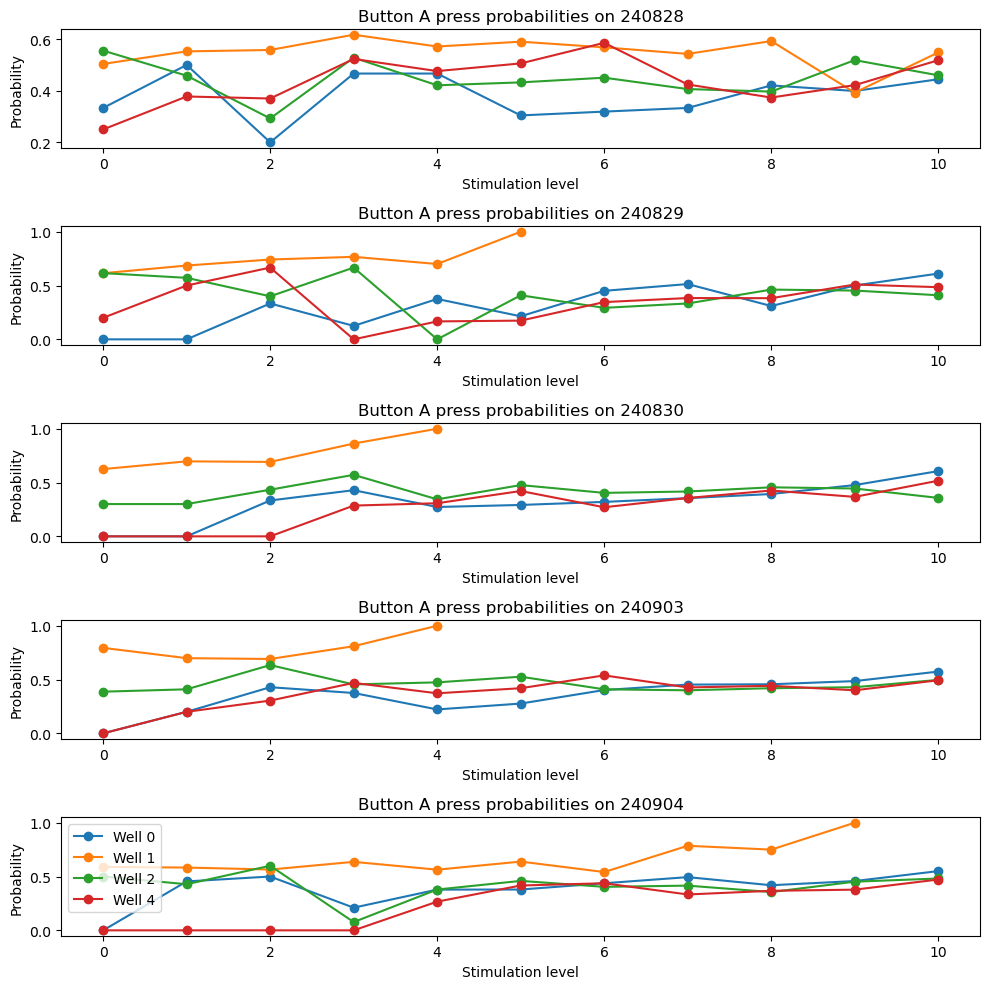

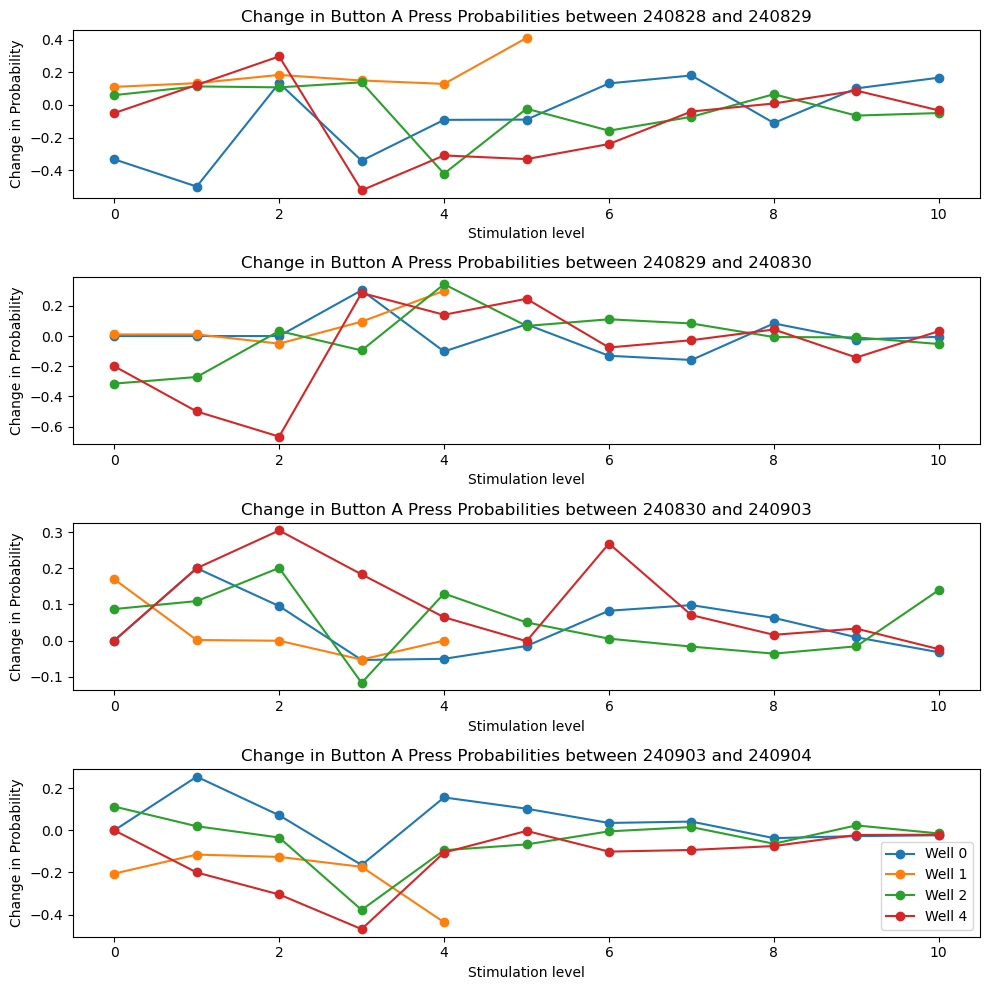

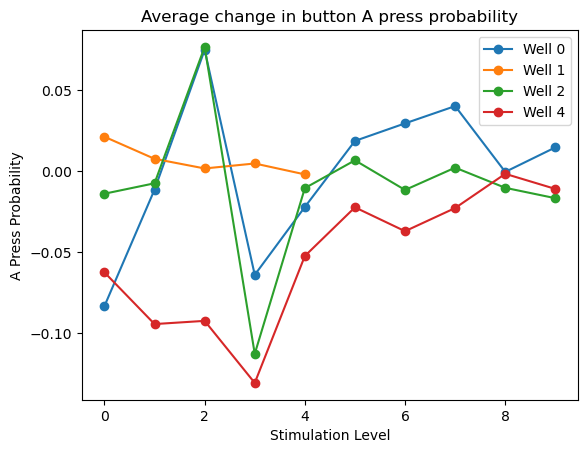

In [30]:
wells = [0, 1, 2, 4]


plot_button_probs(wells)
plot_button_a_probs_change(wells)
plot_average_button_probs(wells)